In [77]:
!nvidia-smi

Mon Jun  1 21:02:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q -U watermark


In [0]:
!pip install -qq transformers

In [80]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.4
pandas 1.0.3
torch 1.5.0+cu101
transformers 2.10.0


In [0]:
#imports
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [82]:
!wget https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/data.csv?token=AFCBJTYYIMZSUMMD5SQTRK2632J7S

--2020-06-01 21:02:34--  https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/data.csv?token=AFCBJTYYIMZSUMMD5SQTRK2632J7S
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977654 (955K) [text/plain]
Saving to: ‘data.csv?token=AFCBJTYYIMZSUMMD5SQTRK2632J7S’

data.csv?token=AFCB 100%[===================>] 954.74K  --.-KB/s    in 0.02s   

2020-06-01 21:02:34 (50.7 MB/s) - ‘data.csv?token=AFCBJTYYIMZSUMMD5SQTRK2632J7S’ saved [977654/977654]



In [0]:
df = pd.read_csv('data.csv')

In [0]:
df = df.drop('Unnamed: 0', 1)

In [0]:
enc_classes={'joy':0,'fear':1,'anger':2,'sadness':3,'digust':4,'shame':5,'guilty':6}
class_name=['joy','fear','anger','sadness','digust','shame','guilty']

def to_number(emotion):
  emotion=str(emotion)
  return enc_classes[emotion]

df['Enc_Emotion'] = df.Emotion.apply(to_number)



In [86]:
df=df.drop('Emotion',1)
df[:8]

,Sentence,Enc_Emotion
0,"During the period of falling in love, each tim...",0
1,When I was involved in a traffic accident.,1
2,When I was driving home after several days of...,2
3,When I lost the person who meant the most to me.,3
4,The time I knocked a deer down - the sight of ...,4
5,When I did not speak the truth.,5
6,When I caused problems for somebody because he...,6
7,When I got a letter offering me the Summer job...,0


In [87]:
df.shape

(7666, 2)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7666 entries, 0 to 7665
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sentence     7666 non-null   object
 1   Enc_Emotion  7666 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.9+ KB


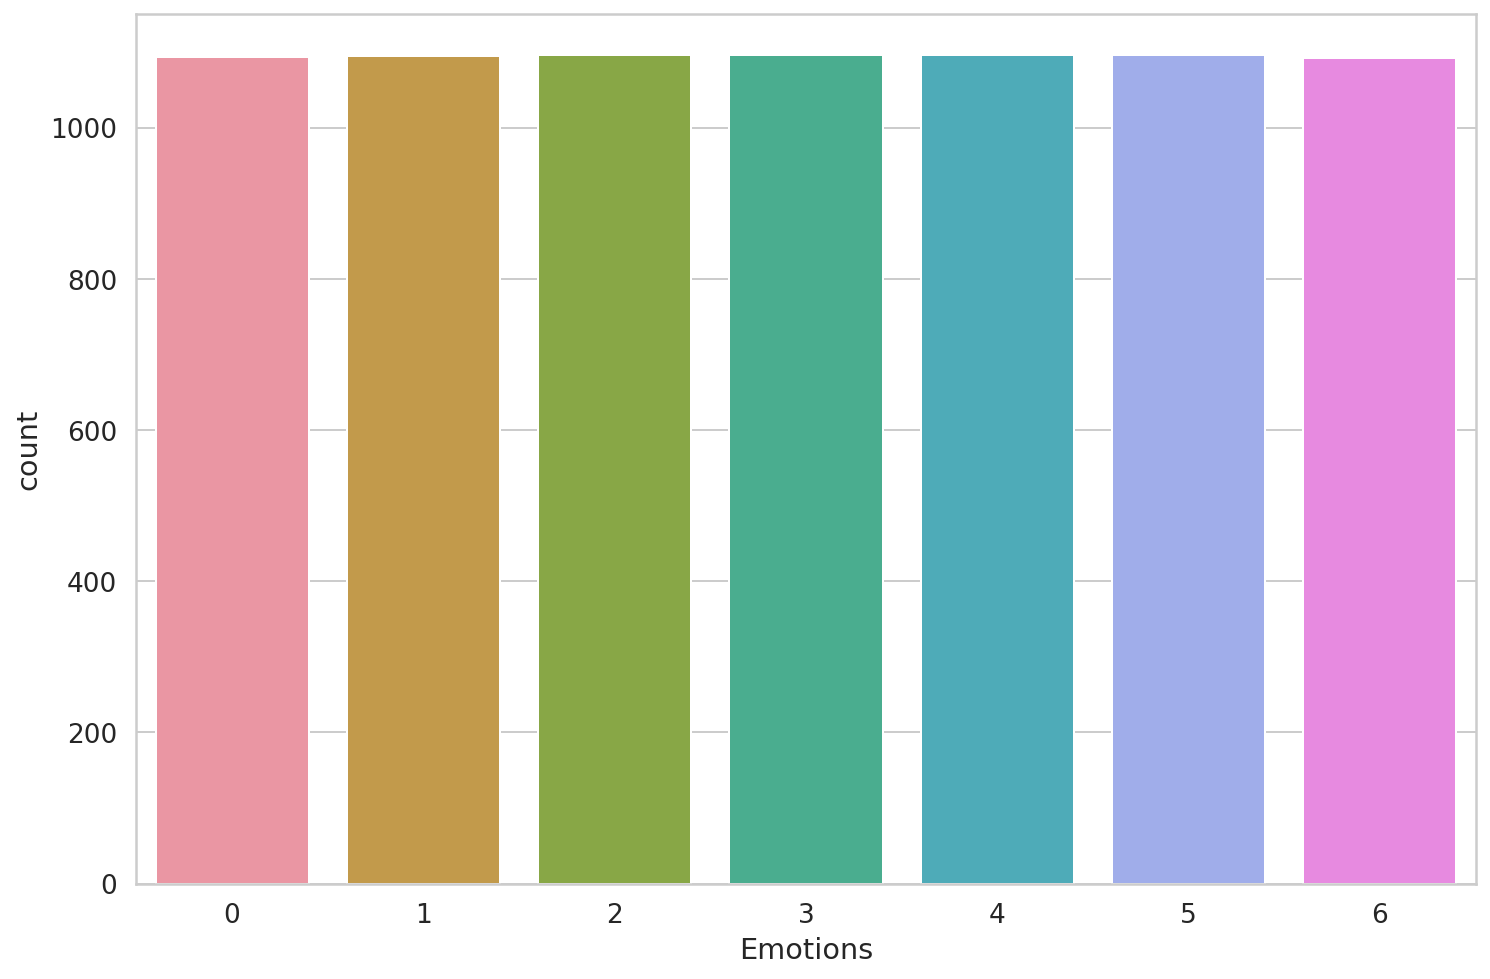

In [90]:
sns.countplot(df.Enc_Emotion)
plt.xlabel('Emotions');

Data is balanced, good

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [0]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [93]:
#SEP TOKEN : marker for ending of a sentence
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [94]:
#CLS TOKEN : we must add this token to the start of each sentence, so BERT knows we're doing classification
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [95]:
#PAD Token: for padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [96]:
#UNK : Unknown Token
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [97]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [98]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [99]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [100]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [0]:
token_lens = []

for txt in df.Sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

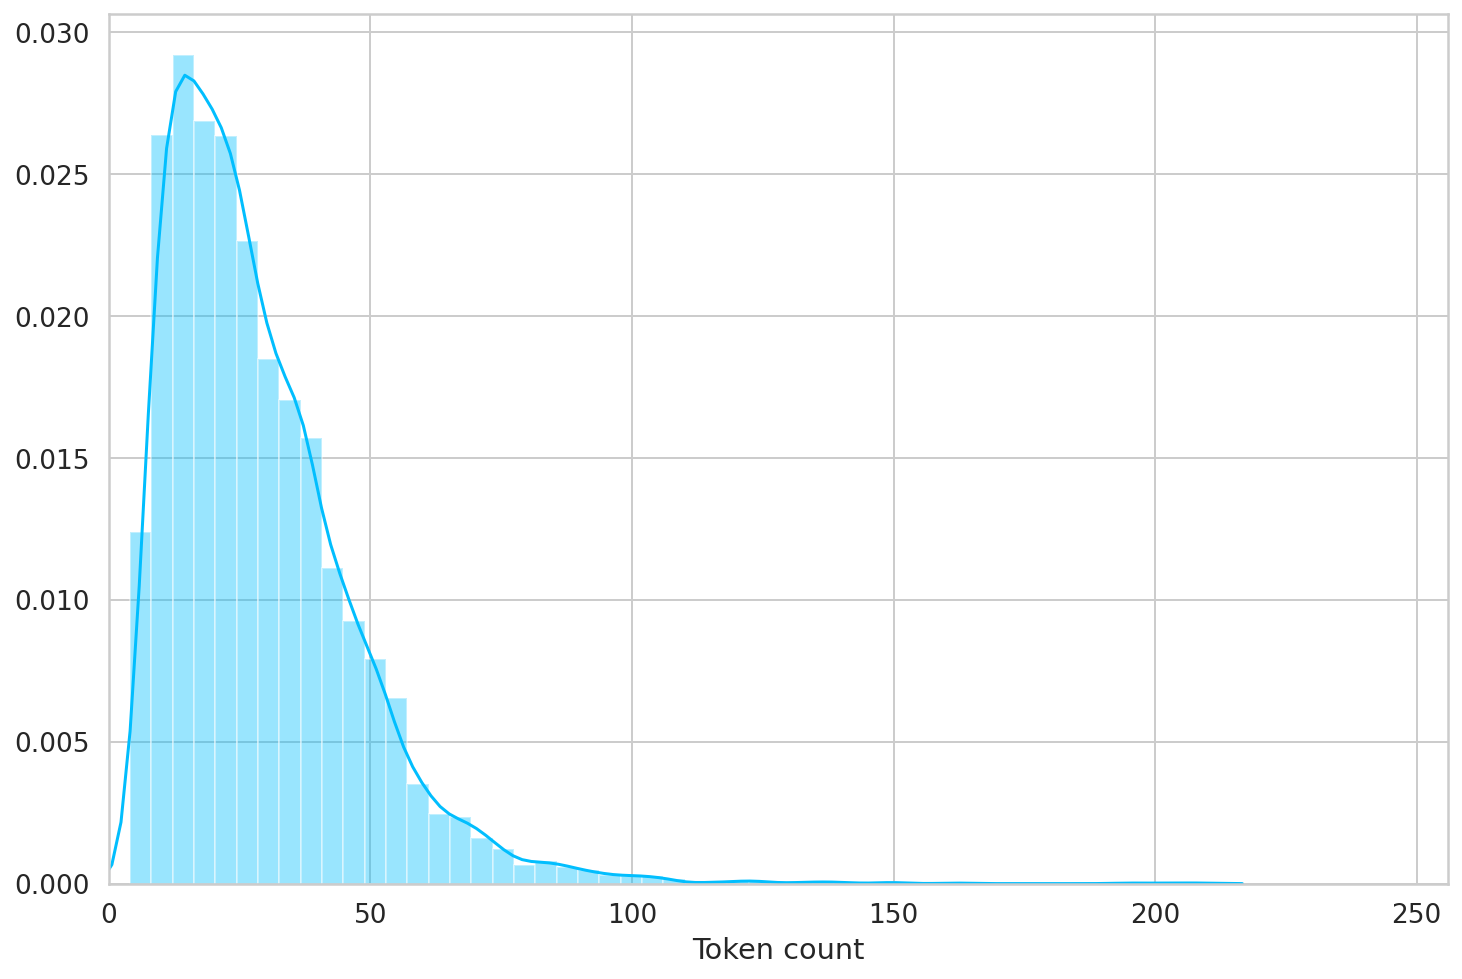

In [102]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [0]:
MAX_LEN = 120

In [0]:
class EmotionReviewDataSet(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [0]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)


In [106]:
df_train.shape, df_val.shape, df_test.shape

((6899, 2), (383, 2), (384, 2))

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = EmotionReviewDataSet(
    reviews=df.Sentence.to_numpy(),
    targets=df.Enc_Emotion.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [112]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [113]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 120])
torch.Size([16, 120])
torch.Size([16])


In [114]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [116]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [117]:
bert_model.config.hidden_size

768

In [118]:
pooled_output.shape

torch.Size([1, 768])

In [0]:
class EmotionClassifier(nn.Module):

  def __init__(self, n_classes):
    super(EmotionClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [0]:
model = EmotionClassifier(len(class_name))
model = model.to(device)

In [122]:
print(model)

EmotionClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [123]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 120])
torch.Size([16, 120])


In [127]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2337, 0.0798, 0.3109, 0.1077, 0.1531, 0.0556, 0.0592],
        [0.3064, 0.1239, 0.1940, 0.0969, 0.1838, 0.0426, 0.0524],
        [0.2512, 0.0864, 0.2170, 0.1008, 0.1685, 0.0623, 0.1139],
        [0.2988, 0.0716, 0.1634, 0.0729, 0.2640, 0.0387, 0.0906],
        [0.2075, 0.1010, 0.1850, 0.1457, 0.2117, 0.0530, 0.0961],
        [0.1655, 0.0616, 0.2052, 0.2244, 0.1999, 0.0518, 0.0916],
        [0.2517, 0.0731, 0.3624, 0.0641, 0.1254, 0.0564, 0.0669],
        [0.3062, 0.0800, 0.1313, 0.1068, 0.2127, 0.0317, 0.1313],
        [0.2341, 0.0646, 0.2261, 0.1274, 0.1661, 0.0707, 0.1110],
        [0.1865, 0.0657, 0.3065, 0.1375, 0.1827, 0.0485, 0.0725],
        [0.2233, 0.0545, 0.3124, 0.0956, 0.1839, 0.0459, 0.0843],
        [0.1369, 0.1174, 0.2516, 0.1447, 0.1460, 0.0418, 0.1616],
        [0.2640, 0.0512, 0.2919, 0.0532, 0.2656, 0.0393, 0.0348],
        [0.3008, 0.0874, 0.3165, 0.0695, 0.1262, 0.0300, 0.0697],
        [0.1821, 0.1105, 0.2680, 0.1439, 0.1273, 0.0542, 0.1139],
        [0

In [0]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [131]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.1475960609537583 accuracy 0.5819684012175678
Val   loss 0.8003448583185673 accuracy 0.7075718015665796

Epoch 2/10
----------
Train loss 0.6232410930959439 accuracy 0.7814175967531527
Val   loss 0.8316635992377996 accuracy 0.7154046997389034

Epoch 3/10
----------
Train loss 0.3665460956765822 accuracy 0.8746195100739238
Val   loss 1.0342170211176078 accuracy 0.7023498694516971

Epoch 4/10
----------
Train loss 0.21834276267650743 accuracy 0.929699956515437
Val   loss 1.2345645558089018 accuracy 0.7101827676240209

Epoch 5/10
----------
Train loss 0.1357043079492373 accuracy 0.9572401797361937
Val   loss 1.4257796481251717 accuracy 0.7232375979112272

Epoch 6/10
----------
Train loss 0.09208465254293212 accuracy 0.9713001884331063
Val   loss 1.5848050955682993 accuracy 0.7023498694516971

Epoch 7/10
----------
Train loss 0.07435452973152644 accuracy 0.9759385418176548
Val   loss 1.6433041673153639 accuracy 0.7023498694516971

Epoch 8/10
----------
Tra

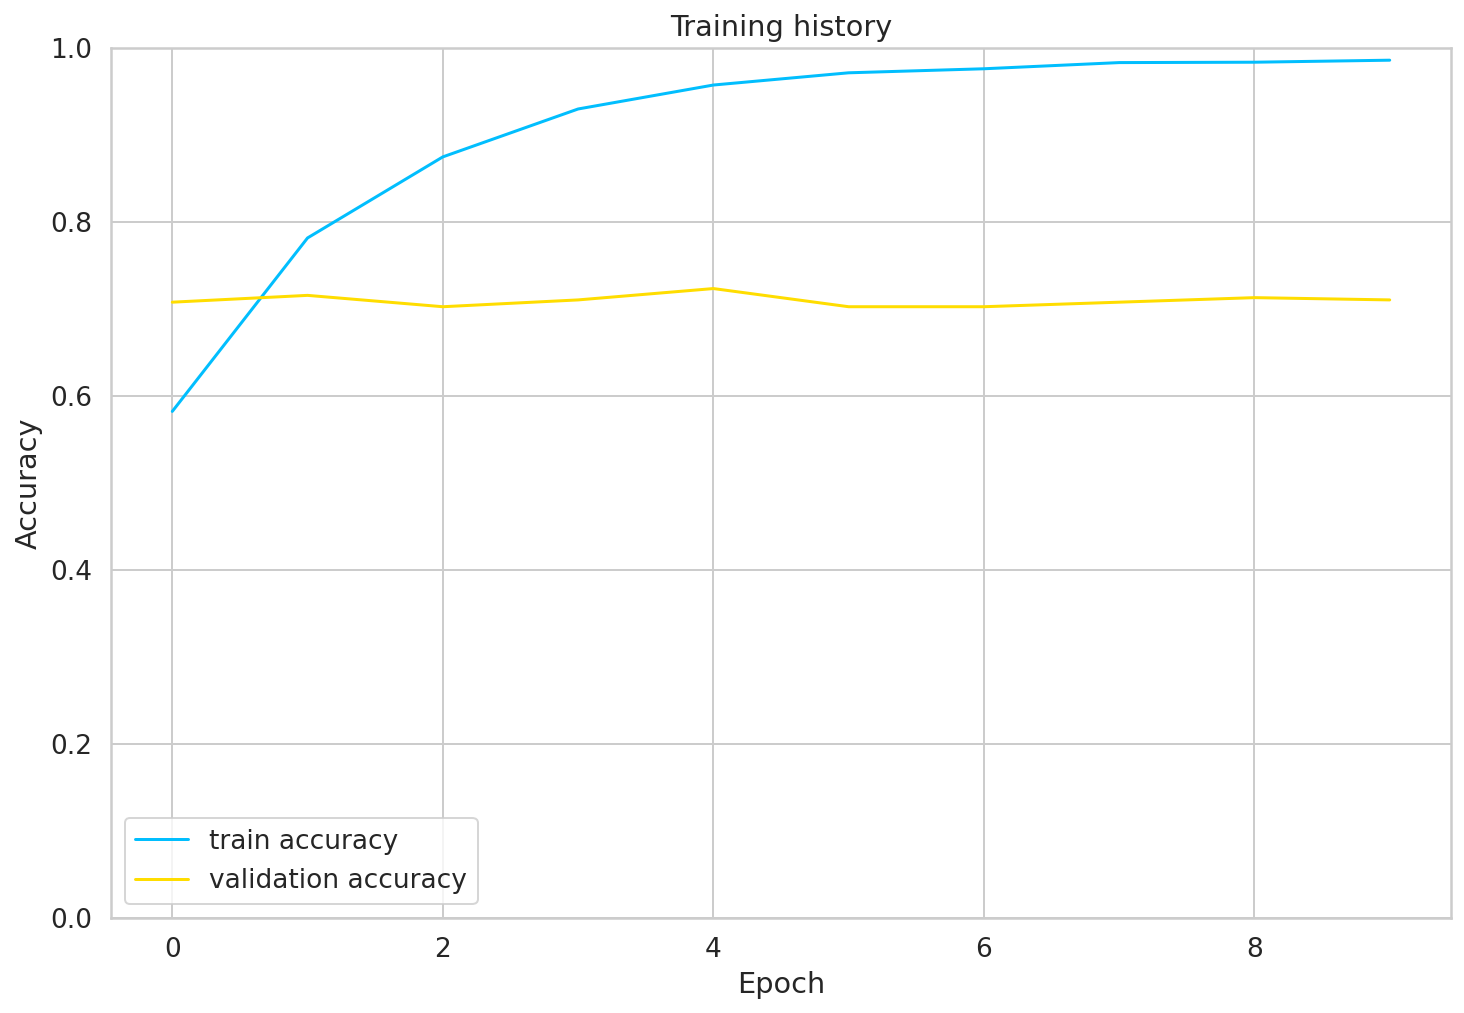

In [132]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [133]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7057291666666666

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [0]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [137]:
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

         joy       0.89      0.96      0.92        57
        fear       0.88      0.75      0.81        61
       anger       0.62      0.58      0.60        55
     sadness       0.77      0.80      0.79        51
      digust       0.78      0.64      0.70        50
       shame       0.51      0.59      0.54        58
      guilty       0.54      0.60      0.57        52

    accuracy                           0.71       384
   macro avg       0.71      0.70      0.71       384
weighted avg       0.72      0.71      0.71       384



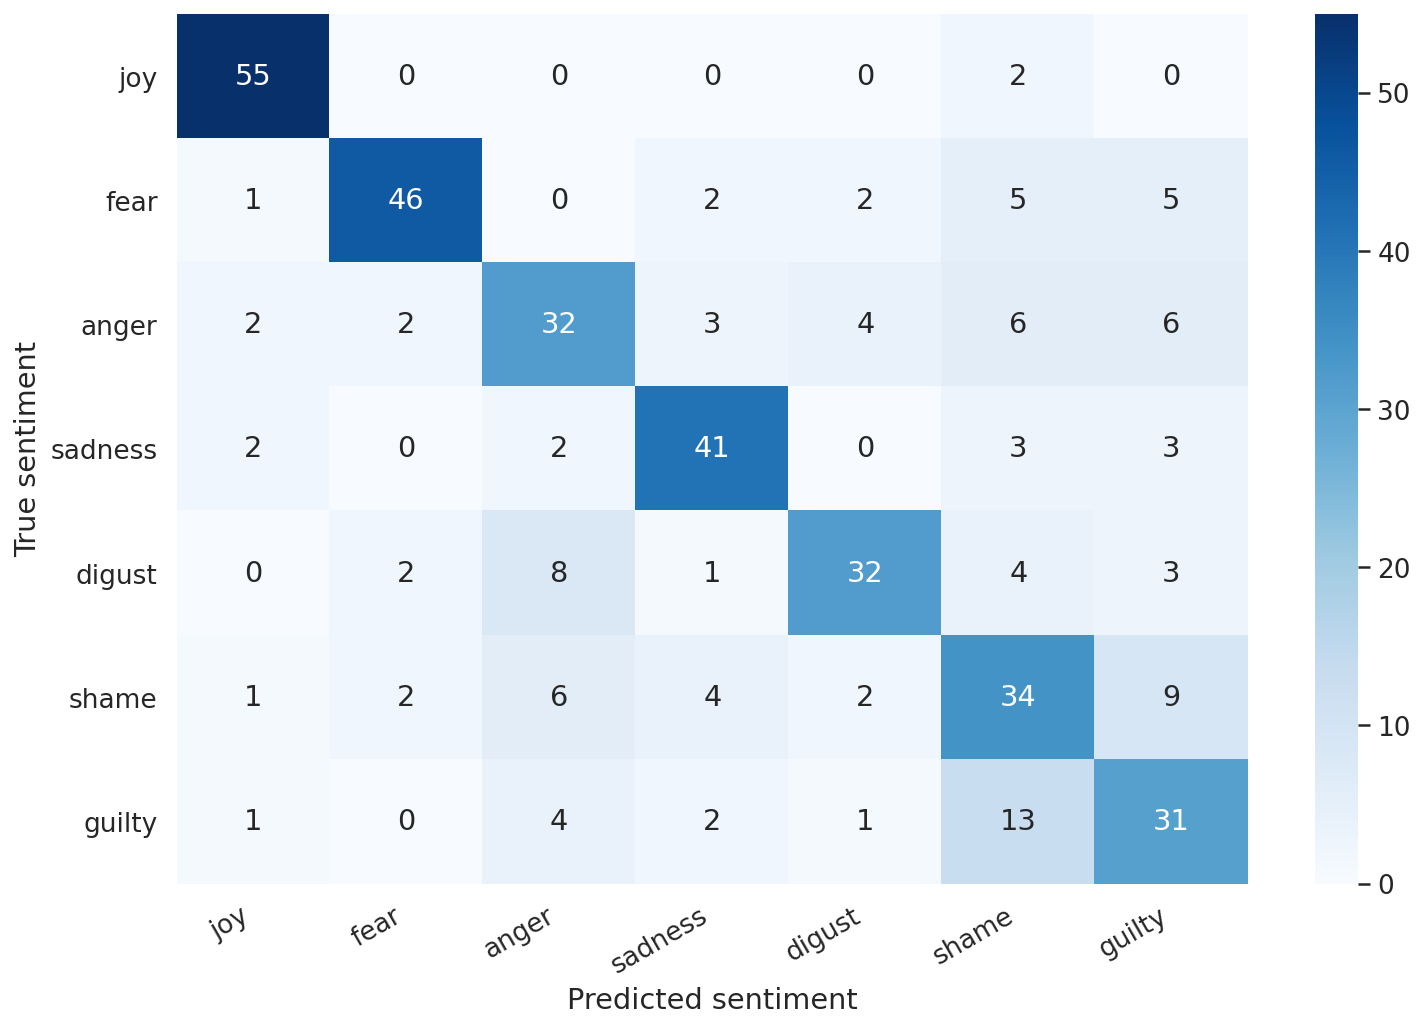

In [138]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [0]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_name,
  'values': y_pred_probs[idx]
})

In [142]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_name[true_sentiment]}')

A class-mate died after being two months in coma, after a car á
accident.

True sentiment: sadness


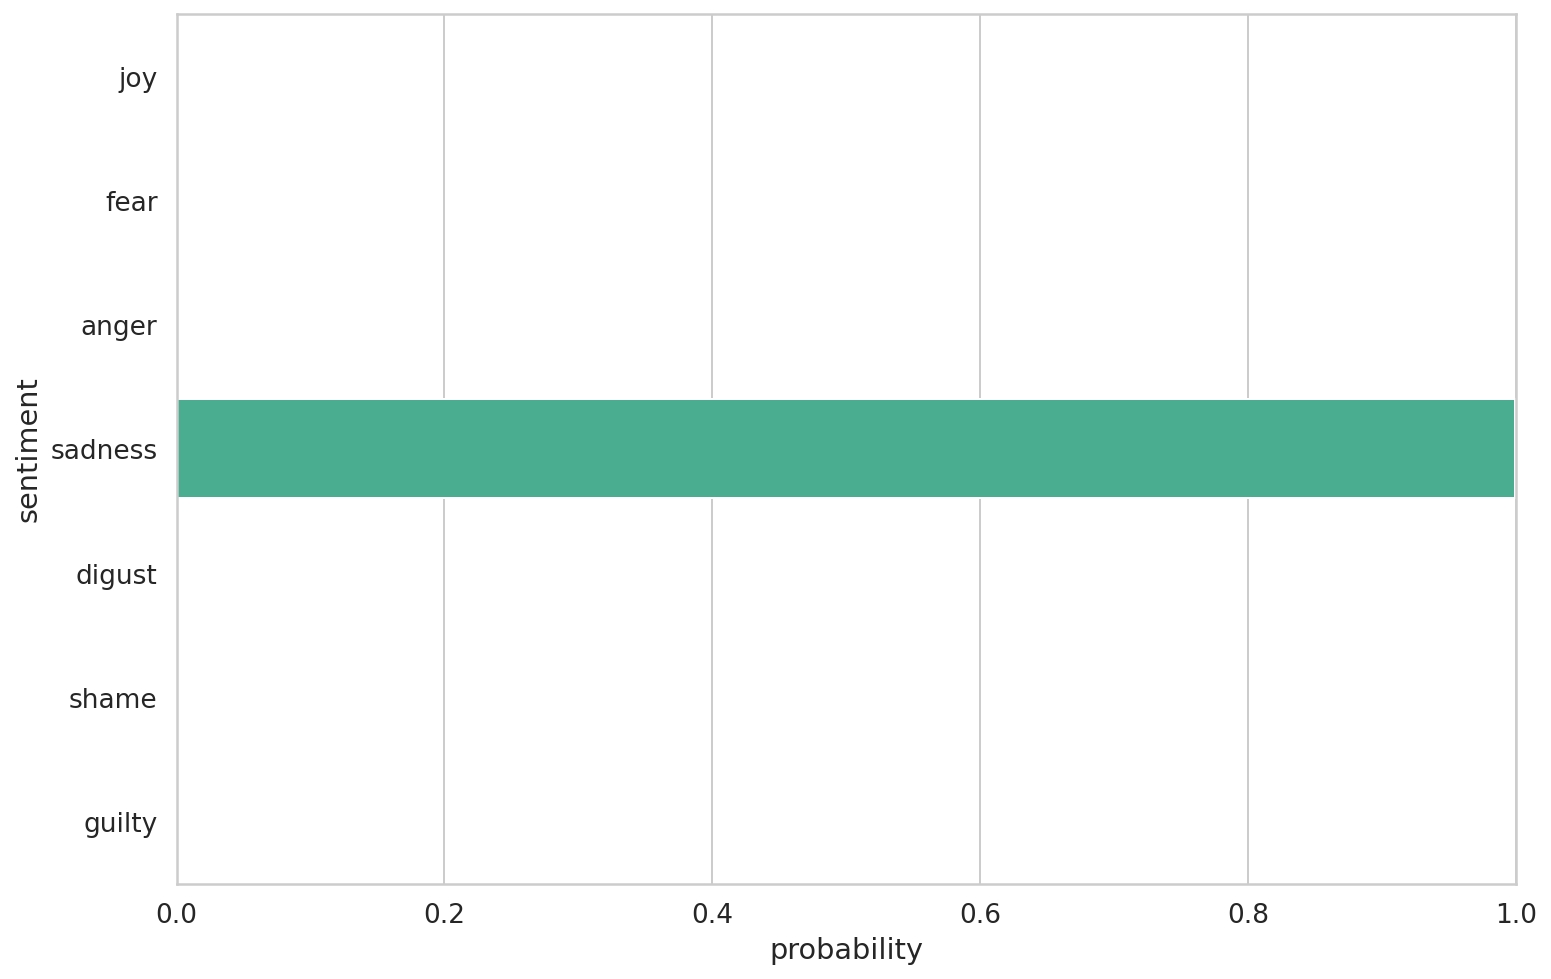

In [143]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [0]:
review_text = "Air bnb cheated me !!!"

In [0]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [152]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

Review text: Air bnb cheated me !!!
Sentiment  : anger
